<a href="https://colab.research.google.com/github/shubymao/comp551-p3/blob/vic/Project_3_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - Convolution Neural Network

## Team Members

Le-Li Mao (260800098)

Victor Livernoche (260926276)

Enan Ashaduzzaman (260805923)

## Initializing Dependency

In [1]:
from __future__ import print_function
import pickle as pkl
import numpy as np
import argparse
from tqdm import tqdm
from sklearn.preprocessing import normalize
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision.transforms.functional as TF
from torchvision.transforms import *
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import string
from google.colab import drive
drive.mount('/content/drive')
# print(torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import tensorflow as tf
tf.test.gpu_device_name()

Mounted at /content/drive
cuda


'/device:GPU:0'

## Loading Data

In [32]:
mapping = list(string.ascii_lowercase) 
training_data, training_labels, testing_data = None, None, None
with open("/content/drive/My Drive/data/images_l.pkl", 'rb') as f: 
    training_data = pkl.load(f)
    validation_size = training_data.shape[0]//10
    validation_data = training_data[0:validation_size]
    training_data = training_data[validation_size:]
with open("/content/drive/My Drive/data/labels_l.pkl", 'rb') as f: 
    training_labels = pkl.load(f)
    validation_size = training_labels.shape[0]//10
    validation_labels = training_labels[0:validation_size]
    training_labels = training_labels[validation_size:]
with open("/content/drive/My Drive/data/images_test.pkl", 'rb') as f: 
    testing_data = pkl.load(f)
with open("/content/drive/My Drive/data/images_ul.pkl", 'rb') as f: 
    unlabeled_data = pkl.load(f)

## Preprocessing

### Preprocessing Helper Functions

In [3]:
def convert_labels_to_readables(labels):
  readables = []
  for label in labels:
    l1, l2 = int(label[0]), mapping[label[1].int()]
    readables.append((l1,l2,))
  return readables

In [4]:
# show images
def img_grid(row,col,imgs):
  if imgs is None: return
  for r in range(row):
    fig, axs = plt.subplots(nrows=1, ncols=col, figsize=(7.,10.))
    for i, ax in enumerate(axs.flatten()):
        if(len(imgs) <= r*col+i): 
          return
        plt.sca(ax)
        plt.imshow(imgs[r*col+i])    
    # plt.colorbar()
    plt.show()

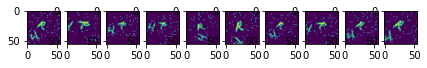

In [31]:
affine_manager = RandomAffine(45, scale = (0.85,1.15),  shear = 15)
def generate_affine(image_tensor, num):
    outputs = []
    for _ in range(num):
      outputs.append(affine_manager(image_tensor))
    return outputs

sample_tensor = torch.from_numpy(training_data[100,None]).float()
affined_tensors = map(lambda x: x[0], generate_affine(sample_tensor,9))
img_grid(1,10,[sample_tensor[0],*affined_tensors])

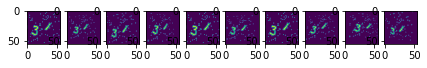

In [6]:
perspective_manager = RandomPerspective(0.4)
def generate_pespective(image_tensor, num):
    outputs = []
    for _ in range(num):
      outputs.append(perspective_manager(image_tensor))
    return outputs

sample_tensor = torch.from_numpy(training_data[2000,None]).float()
perspective_tensors = map(lambda x: x[0], generate_pespective(sample_tensor,9))
img_grid(1,10,[sample_tensor[0],*perspective_tensors])

In [7]:
# transform all data to the output format
def process_training_data(data, labels, affine_cnt = 0, perspective_cnt = 0):
  multiplier = (1+affine_cnt+perspective_cnt)
  data_tensor = torch.from_numpy(data[:,None]).float()
  new_data = torch.empty((len(data)*multiplier,1,56,56))
  num_labels = torch.empty(len(data)*multiplier)
  letter_labels = torch.empty(len(data)*multiplier)
  output_index = 0
  for i in tqdm(range(len(data_tensor))):
    # Assign the labels to the new data
    num_labels[i*multiplier:(i+1)*multiplier] = int(np.argmax(labels[i,0:10]))
    letter_labels[i*multiplier:(i+1)*multiplier] = int(np.argmax(labels[i,10:]))
    # Creating the rotation and sharpness images
    mean, std = torch.mean(data_tensor[i]), torch.std(data_tensor[i])
    norm_img = TF.normalize(data_tensor[i], [mean], [std])
    new_data[output_index] = norm_img; output_index+=1
    for r_img in generate_affine(norm_img, affine_cnt):
      new_data[output_index] = r_img; output_index+=1
    for s_img in generate_pespective(norm_img, perspective_cnt):
      new_data[output_index] = s_img; output_index+=1
  
  # Creating the datasets
  multi_label_tensor = torch.stack((num_labels,letter_labels), axis=1).long()
  dataset = TensorDataset(new_data, multi_label_tensor)
  return dataset
  

In [8]:
# transform all data to the output format
def process_unlabeled_data(data, labels, affine_cnt = 0, perspective_cnt = 0):
  multiplier = (1+affine_cnt+perspective_cnt)
  data_tensor = torch.from_numpy(data[:,None]).float()
  new_data = torch.empty((len(data)*multiplier,1,56,56))
  num_labels = torch.empty(len(data)*multiplier)
  letter_labels = torch.empty(len(data)*multiplier)
  output_index = 0
  for i in tqdm(range(len(data_tensor))):
    # Assign the labels to the new data
    num_labels[i*multiplier:(i+1)*multiplier] = labels[i,0]
    letter_labels[i*multiplier:(i+1)*multiplier] = labels[i,1]
    # Creating the rotation and sharpness images
    mean, std = torch.mean(data_tensor[i]), torch.std(data_tensor[i])
    norm_img = TF.normalize(data_tensor[i], [mean], [std])
    new_data[output_index] = norm_img; output_index+=1
    for r_img in generate_affine(norm_img, affine_cnt):
      new_data[output_index] = r_img; output_index+=1
    for s_img in generate_pespective(norm_img, perspective_cnt):
      new_data[output_index] = s_img; output_index+=1
  
  # Creating the datasets
  multi_label_tensor = torch.stack((num_labels,letter_labels), axis=1).long()
  dataset = TensorDataset(new_data, multi_label_tensor)
  return dataset

In [9]:
def process_testing_data(data):
  data_tensor = torch.from_numpy(data[:,None]).float()
  dataset = torch.empty((len(data),1,56,56))
  for i in tqdm(range(len(data_tensor))):
    mean, std = torch.mean(data_tensor[i]), torch.std(data_tensor[i])
    norm_img = TF.normalize(data_tensor[i], [mean], [std])
    dataset[i] = norm_img
  return dataset
testing_dataset = process_testing_data(testing_data)

100%|██████████| 15000/15000 [00:01<00:00, 12901.15it/s]


### Processing The Data

Process the data and put the data into dataloader

In [33]:
def make_data_loader(dataset, batch_size=30, shuffle=True, num_workers=2):
  dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
  return dataloader

print("Processing Training Data")
training_dataset = process_training_data(training_data, training_labels, 4, 2)
print("Processing Validation Data")
validation_dataset = process_training_data(validation_data,validation_labels)

#training_loader = make_data_loader(training_dataset)
validation_loader = make_data_loader(validation_dataset)

Processing Training Data


100%|██████████| 27000/27000 [01:02<00:00, 429.16it/s]


Processing Validation Data


100%|██████████| 3000/3000 [00:00<00:00, 8619.28it/s]


In [34]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from PIL import Image
import h5py
 
class dataset_h5(torch.utils.data.Dataset):
    def __init__(self, in_file, transform=None):
        super(dataset_h5, self).__init__()
 
        self.file = h5py.File(in_file, 'r')
        self.transform = transform
 
    def __getitem__(self, index):
        x = self.file['X_train'][index, ...]
        y = self.file['Y_train'][index, ...]
        
        # Preprocessing each image
        if self.transform is not None:
            x = self.transform(x)        
        
        return x, y
 
    def __len__(self):
        return self.file['X_train'].shape[0]
training_set, training_labels = training_dataset[:]
with h5py.File('data.h', "w") as out:
   out['X_train'] = training_set
   out['Y_train'] = training_labels
dataset = dataset_h5("data.h")
training_loader = DataLoader(
        dataset, batch_size=30, shuffle=True, num_workers=2)

OSError: ignored

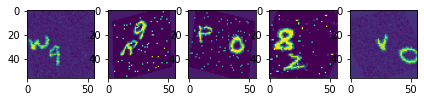

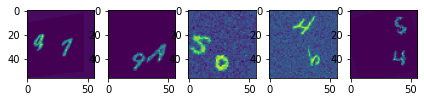

[(9, 'w'), (9, 'r'), (0, 'p'), (8, 'z'), (0, 'v'), (7, 'g'), (9, 'a'), (0, 's'), (4, 'b'), (4, 's')]


In [12]:
def show_sample(n):
  perm = torch.randperm(len(training_dataset))
  idx = perm[:n]
  data, labels = training_dataset[idx]
  img_grid(n//5,5 , data[:,0])
  print(convert_labels_to_readables(labels))
show_sample(10)

## Training Model

### Multi-Output Model

Initalize the Multilabel Model

In [13]:
class MultiNet(nn.Module):
    def __init__(self):
        super(MultiNet, self).__init__()
         # 4 convolution layer
        self.conv1 = nn.Conv2d(1, 64, 3, padding='same')
        self.conv2 = nn.Conv2d(64, 64, 3, padding='same')
        self.conv3 = nn.Conv2d(64, 128, 3, padding='same')
        self.conv4 = nn.Conv2d(128, 256, 3, padding='same')
        
        self.pool2 = nn.MaxPool2d(2, 2)

        # 3 Dense Layer
        self.fc11 = nn.Linear(256*3*3, 1000)
        self.fc12 = nn.Linear(256*3*3, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 1000)
        self.fc31 = nn.Linear(100, 10)
        self.fc32 = nn.Linear(1000, 26)

    def forward(self, x):
        # Convolution Layers
        x = F.relu(self.conv1(x))
        x = self.pool2(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        # print(x.size())
        # Dense Layers
        x = x.view(-1,self.num_flat_features(x)) # Flatten
        l1 = F.relu(self.fc21(F.relu(self.fc11(x))))
        l2 = F.relu(self.fc22(F.relu(self.fc12(x))))
        l1 = self.fc31(l1)
        l2 = self.fc32(l2)
        return l1,l2
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Custom Res Net with Multi Output




In [35]:
class Block(nn.Module):
  def __init__(self, inplane, outplane, stride = 1):
    super(Block, self).__init__()
    self.inplane = inplane
    self.outplane = outplane
    self.relu = nn.ReLU(inplace=True)
    
    self.conv1 = nn.Conv2d(inplane, outplane, 3, padding=1, bias=False, stride=stride)
    self.bn1 = nn.BatchNorm2d(outplane)
    self.conv2 = nn.Conv2d(outplane, outplane, 3, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(outplane)
    
    self.convi, self.bni = nn.Identity(), nn.Identity()
    if inplane != outplane or stride != 1: 
      self.convi = nn.Conv2d(inplane, outplane, 1, bias=False, stride=stride)
      self.bni = nn.BatchNorm2d(outplane)
  
  def forward(self, x):
        identity = self.bni(self.convi(x))

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 24, 3, padding=2, bias=False)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(24)
        
        # 6 Residual Layers
        self.layer1 = Block(24, 24)
        self.layer2 = Block(24, 48, 2)
        self.layer3 = Block(48, 48)
        self.layer4 = Block(48, 96, 2)
        self.layer5 = Block(96, 96)
        self.layer6 = Block(96, 192, 2)
        self.layer7 = Block(192, 192)

        # self.layer4 = self._make_layer(models.resnet.BasicBlock, 512, 1, stride=2)
        self.avgpool = nn.AvgPool2d(3, stride=1)
        self.fc = nn.Linear(768, 3000)
        self.fc1 = nn.Linear(3000, 1200)
        self.fc2 = nn.Linear(3000, 2000)
        self.fc11 = nn.Linear(1200, 10)
        self.fc21 = nn.Linear(2000, 26)        

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = torch.sigmoid(self.fc(x))
        l1 = self.fc11(F.relu(self.fc1(x)))
        l2 = self.fc21(F.relu(self.fc2(x)))
        return l1,l2

### Training and Validation

Initialize network validation and training function

In [15]:
def validate_model(model):
  digit_acc, letter_acc = 0, 0
  print("Starting Validation Iteration")
  for i, validation_data in enumerate(tqdm(validation_loader)):
    inputs, labels = validation_data
    o1, o2 = model(inputs)
    l1, l2 = labels[:,0], labels[:,1]
    digit_acc += torch.mean((torch.argmax(o1, dim=1) == l1).float()).float()
    letter_acc += torch.mean((torch.argmax(o2, dim=1) == l2).float())
  digit_acc = digit_acc/len(validation_loader)
  letter_acc = letter_acc / len(validation_loader)
  print(f'\n Digit Accuracy: {digit_acc.item()}, Letter Accuracy: {letter_acc.item()}')
  return (digit_acc.item(), letter_acc.item())

In [16]:
def train_network(net, optimizer, criterion, max_epoch = 10, last_index = len(training_loader), do_validation = True, loader = training_loader):
  running_loss = 0.0
  digits_accs, letter_accs = [], []
  for epoch in range(max_epoch):  # loop over the dataset multiple times
      cnt = 0
      print("Starting Training Iteration")
      for i, data in enumerate(tqdm(loader)):
          if epoch == max_epoch - 1 and i > last_index:
            break
          inputs, labels = data
          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          cnt+=1
          if i % 100 == 99:
            print('[%d] loss: %.3f' % (i // 100, running_loss / cnt))
            running_loss, cnt = 0.0, 0
      if do_validation:
        digit_acc, letter_acc = validate_model(net)
        digits_accs.append(digit_acc)
        letter_accs.append(letter_acc)
        return (digits_accs, letter_accs)

In [36]:
def train_model(net, optimizer, do_validation = True, epoch = 1, last_index = len(training_loader), loader= training_loader):
  multi_net_criterion = nn.CrossEntropyLoss()
  def ml_criterion(output, labels):
    o1, o2 = output
    l1, l2 = labels[:,0], labels[:,1]
    loss1 = multi_net_criterion(o1,l1)
    loss2 = multi_net_criterion(o2,l2)
    return loss1 + loss2
  if do_validation:
    res = train_network(net, optimizer, criterion=ml_criterion, max_epoch=epoch, last_index=last_index, loader = loader)
    digit_accuracies, letter_accuracies = res
  else: 
    res = train_network(net, optimizer, criterion=ml_criterion,  max_epoch=epoch, last_index=last_index, do_validation=do_validation, loader = loader)
  return net

lr, momentum, weight_decay = 0.009, 0.9, 1e-5
net = CustomResNet()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
net = train_model(net, optimizer, epoch = 1)

Starting Training Iteration


  2%|▏         | 100/6300 [00:24<24:23,  4.24it/s]

[0] loss: 5.597


  3%|▎         | 200/6300 [00:47<23:48,  4.27it/s]

[1] loss: 5.562


  5%|▍         | 300/6300 [01:11<23:23,  4.27it/s]

[2] loss: 5.542


  6%|▋         | 400/6300 [01:34<22:58,  4.28it/s]

[3] loss: 5.441


  8%|▊         | 500/6300 [01:58<22:28,  4.30it/s]

[4] loss: 5.353


 10%|▉         | 600/6300 [02:21<22:22,  4.25it/s]

[5] loss: 5.299


 11%|█         | 678/6300 [02:40<22:10,  4.23it/s]


KeyboardInterrupt: ignored

In [29]:
lr, momentum, weight_decay = 0.00001, 0.92, 1e-5
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
net = train_model(net, optimizer, epoch = 1, last_index=len(training_loader))

Starting Training Iteration


  2%|▏         | 100/6300 [00:28<28:46,  3.59it/s]

[0] loss: 0.455


  3%|▎         | 200/6300 [00:56<28:32,  3.56it/s]

[1] loss: 0.485


  5%|▍         | 300/6300 [01:23<27:21,  3.65it/s]

[2] loss: 0.435


  6%|▋         | 400/6300 [01:51<27:08,  3.62it/s]

[3] loss: 0.438


  8%|▊         | 500/6300 [02:18<26:37,  3.63it/s]

[4] loss: 0.421


 10%|▉         | 600/6300 [02:46<26:00,  3.65it/s]

[5] loss: 0.423


 11%|█         | 700/6300 [03:14<26:10,  3.57it/s]

[6] loss: 0.408


 13%|█▎        | 800/6300 [03:42<25:40,  3.57it/s]

[7] loss: 0.428


 14%|█▍        | 900/6300 [04:09<23:57,  3.76it/s]

[8] loss: 0.411


 16%|█▌        | 1000/6300 [04:37<23:36,  3.74it/s]

[9] loss: 0.436


 17%|█▋        | 1100/6300 [05:03<22:59,  3.77it/s]

[10] loss: 0.381


 19%|█▉        | 1200/6300 [05:31<22:57,  3.70it/s]

[11] loss: 0.402


 21%|██        | 1300/6300 [05:58<22:55,  3.64it/s]

[12] loss: 0.363


 22%|██▏       | 1400/6300 [06:25<22:36,  3.61it/s]

[13] loss: 0.426


 24%|██▍       | 1500/6300 [06:51<21:13,  3.77it/s]

[14] loss: 0.408


 25%|██▌       | 1600/6300 [07:18<20:56,  3.74it/s]

[15] loss: 0.436


 27%|██▋       | 1700/6300 [07:45<20:15,  3.78it/s]

[16] loss: 0.418


 29%|██▊       | 1800/6300 [08:12<19:58,  3.75it/s]

[17] loss: 0.419


 30%|███       | 1900/6300 [08:39<19:57,  3.68it/s]

[18] loss: 0.402


 32%|███▏      | 2000/6300 [09:06<19:13,  3.73it/s]

[19] loss: 0.388


 33%|███▎      | 2100/6300 [09:33<18:52,  3.71it/s]

[20] loss: 0.432


 35%|███▍      | 2200/6300 [10:00<18:20,  3.73it/s]

[21] loss: 0.438


 37%|███▋      | 2300/6300 [10:27<17:32,  3.80it/s]

[22] loss: 0.425


 38%|███▊      | 2400/6300 [10:54<17:31,  3.71it/s]

[23] loss: 0.446


 40%|███▉      | 2500/6300 [11:20<16:47,  3.77it/s]

[24] loss: 0.410


 41%|████▏     | 2600/6300 [11:47<16:16,  3.79it/s]

[25] loss: 0.417


 43%|████▎     | 2700/6300 [12:14<15:55,  3.77it/s]

[26] loss: 0.419


 44%|████▍     | 2757/6300 [12:29<16:03,  3.68it/s]


KeyboardInterrupt: ignored

In [30]:
validate_model(net)

Starting Validation Iteration


100%|██████████| 100/100 [00:09<00:00, 10.01it/s]


 Digit Accuracy: 0.9540002942085266, Letter Accuracy: 0.9126670956611633


(0.9540002942085266, 0.9126670956611633)

In [19]:
def PredictUnlabeled(model, threshold):
  labels = []
  data = []
  k = 0
  while(k<30000):
    r = k+500
    if r > len(unlabeled_data):
      r = len(unlabeled_data)
    l1,l2 = model(torch.from_numpy(unlabeled_data[k:r, None]).float())
    n1 = np.argmax(l1.detach().numpy(), axis=1)
    n2 = np.argmax(l2.detach().numpy(), axis=1)
    for j in range(0, len(n1)):
      if l1[j,n1[j]] > threshold and l2[j,n2[j]] > threshold: # add a threshold of confidence
        labels.append([n1[j], n2[j]])
        data.append(unlabeled_data[k+j])
    k += 500
  print('Number of confident data: ', len(labels))
  return np.array(data), np.array(labels)

In [24]:
unlabeled_predicted_data, unlabeled_labels = PredictUnlabeled(net, 10)
unlabeled_dataset = process_unlabeled_data(unlabeled_predicted_data, unlabeled_labels, 4, 2)

unlabeled_predicted_data, unlabeled_labels = unlabeled_dataset[:]

with h5py.File('data2.h', "w") as out:
   out['X_train'] = unlabeled_predicted_data
   out['Y_train'] = unlabeled_labels
unlabeled_dataset = dataset_h5("data2.h")

final_training_dataset = torch.utils.data.ConcatDataset([dataset, unlabeled_dataset])

final_training_dataloader = DataLoader(final_training_dataset, batch_size=30, shuffle=True, num_workers=2)

# train with the training and unlabeled data
lr, momentum, weight_decay = 0.009, 0.9, 1e-5
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
net = CustomResNet()
net = train_model(net, optimizer, epoch = 1, last_index=len(training_loader), loader =  final_training_dataloader)

Number of confident data:  11134


100%|██████████| 11134/11134 [00:24<00:00, 458.12it/s]


Starting Training Iteration


  1%|          | 100/8898 [00:28<41:12,  3.56it/s]

[0] loss: 6.083


  2%|▏         | 156/8898 [00:44<41:34,  3.51it/s]


KeyboardInterrupt: ignored

In [21]:
# train with the training and unlabeled data
lr, momentum, weight_decay = 0.009, 0.9, 1e-5
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
net = train_model(net, optimizer, epoch = 2, last_index=len(training_loader), loader =  final_training_dataloader)

Starting Training Iteration


  1%|          | 100/9163 [00:28<42:46,  3.53it/s]

[0] loss: 6.465


  2%|▏         | 200/9163 [00:57<42:56,  3.48it/s]

[1] loss: 5.536


  3%|▎         | 300/9163 [01:25<42:48,  3.45it/s]

[2] loss: 5.364


  4%|▍         | 400/9163 [01:54<43:09,  3.38it/s]

[3] loss: 5.257


  5%|▌         | 500/9163 [02:23<41:14,  3.50it/s]

[4] loss: 5.124


  7%|▋         | 600/9163 [02:52<40:57,  3.48it/s]

[5] loss: 4.946


  8%|▊         | 700/9163 [03:21<40:57,  3.44it/s]

[6] loss: 4.803


  9%|▊         | 800/9163 [03:50<40:26,  3.45it/s]

[7] loss: 4.503


 10%|▉         | 900/9163 [04:19<40:23,  3.41it/s]

[8] loss: 4.192


 11%|█         | 1000/9163 [04:48<38:51,  3.50it/s]

[9] loss: 3.847


 12%|█▏        | 1100/9163 [05:16<38:12,  3.52it/s]

[10] loss: 3.500


 13%|█▎        | 1200/9163 [05:45<38:29,  3.45it/s]

[11] loss: 3.165


 14%|█▍        | 1300/9163 [06:14<36:37,  3.58it/s]

[12] loss: 2.928


 15%|█▌        | 1400/9163 [06:42<37:29,  3.45it/s]

[13] loss: 2.724


 16%|█▋        | 1500/9163 [07:11<36:21,  3.51it/s]

[14] loss: 2.448


 17%|█▋        | 1600/9163 [07:40<35:24,  3.56it/s]

[15] loss: 2.214


 19%|█▊        | 1700/9163 [08:08<35:41,  3.48it/s]

[16] loss: 2.086


 20%|█▉        | 1800/9163 [08:37<35:40,  3.44it/s]

[17] loss: 1.956


 21%|██        | 1900/9163 [09:06<34:59,  3.46it/s]

[18] loss: 1.829


 22%|██▏       | 2000/9163 [09:35<34:12,  3.49it/s]

[19] loss: 1.714


 23%|██▎       | 2100/9163 [10:04<34:31,  3.41it/s]

[20] loss: 1.635


 24%|██▍       | 2200/9163 [10:33<34:13,  3.39it/s]

[21] loss: 1.559


 25%|██▌       | 2300/9163 [11:02<33:29,  3.41it/s]

[22] loss: 1.444


 26%|██▌       | 2400/9163 [11:31<32:38,  3.45it/s]

[23] loss: 1.368


 27%|██▋       | 2500/9163 [12:00<32:18,  3.44it/s]

[24] loss: 1.308


 28%|██▊       | 2600/9163 [12:30<32:41,  3.35it/s]

[25] loss: 1.278


 29%|██▉       | 2700/9163 [12:59<31:47,  3.39it/s]

[26] loss: 1.208


 31%|███       | 2800/9163 [13:28<31:44,  3.34it/s]

[27] loss: 1.184


 32%|███▏      | 2900/9163 [13:57<30:30,  3.42it/s]

[28] loss: 1.141


 33%|███▎      | 3000/9163 [14:26<29:56,  3.43it/s]

[29] loss: 1.097


 34%|███▍      | 3100/9163 [14:56<29:34,  3.42it/s]

[30] loss: 1.056


 35%|███▍      | 3200/9163 [15:25<30:05,  3.30it/s]

[31] loss: 1.094


 36%|███▌      | 3300/9163 [15:55<28:12,  3.46it/s]

[32] loss: 0.982


 37%|███▋      | 3400/9163 [16:24<28:04,  3.42it/s]

[33] loss: 1.001


 38%|███▊      | 3500/9163 [16:53<28:23,  3.32it/s]

[34] loss: 0.939


 39%|███▉      | 3600/9163 [17:23<27:24,  3.38it/s]

[35] loss: 0.894


 40%|████      | 3700/9163 [17:52<27:01,  3.37it/s]

[36] loss: 0.972


 41%|████▏     | 3800/9163 [18:21<26:39,  3.35it/s]

[37] loss: 0.953


 43%|████▎     | 3900/9163 [18:51<25:39,  3.42it/s]

[38] loss: 0.886


 44%|████▎     | 4000/9163 [19:20<25:29,  3.38it/s]

[39] loss: 0.816


 45%|████▍     | 4100/9163 [19:50<24:45,  3.41it/s]

[40] loss: 0.881


 46%|████▌     | 4200/9163 [20:20<24:18,  3.40it/s]

[41] loss: 0.788


 47%|████▋     | 4300/9163 [20:49<23:51,  3.40it/s]

[42] loss: 0.778


 48%|████▊     | 4400/9163 [21:19<23:17,  3.41it/s]

[43] loss: 0.772


 49%|████▉     | 4500/9163 [21:49<23:08,  3.36it/s]

[44] loss: 0.773


 50%|█████     | 4600/9163 [22:19<22:35,  3.37it/s]

[45] loss: 0.770


 51%|█████▏    | 4700/9163 [22:48<21:57,  3.39it/s]

[46] loss: 0.753


 52%|█████▏    | 4800/9163 [23:17<21:33,  3.37it/s]

[47] loss: 0.724


 53%|█████▎    | 4900/9163 [23:47<20:34,  3.45it/s]

[48] loss: 0.733


 55%|█████▍    | 5000/9163 [24:16<20:15,  3.42it/s]

[49] loss: 0.724


 56%|█████▌    | 5100/9163 [24:46<19:48,  3.42it/s]

[50] loss: 0.683


 57%|█████▋    | 5200/9163 [25:16<19:38,  3.36it/s]

[51] loss: 0.715


 58%|█████▊    | 5300/9163 [25:45<18:57,  3.40it/s]

[52] loss: 0.677


 59%|█████▉    | 5400/9163 [26:15<18:23,  3.41it/s]

[53] loss: 0.691


 60%|██████    | 5500/9163 [26:44<18:19,  3.33it/s]

[54] loss: 0.721


 61%|██████    | 5600/9163 [27:14<17:43,  3.35it/s]

[55] loss: 0.615


 62%|██████▏   | 5700/9163 [27:44<17:15,  3.34it/s]

[56] loss: 0.630


 63%|██████▎   | 5800/9163 [28:13<16:25,  3.41it/s]

[57] loss: 0.602


 64%|██████▍   | 5900/9163 [28:43<16:02,  3.39it/s]

[58] loss: 0.581


 65%|██████▌   | 6000/9163 [29:12<15:18,  3.44it/s]

[59] loss: 0.666


 67%|██████▋   | 6100/9163 [29:41<14:59,  3.40it/s]

[60] loss: 0.598


 68%|██████▊   | 6200/9163 [30:11<14:25,  3.42it/s]

[61] loss: 0.593


 69%|██████▉   | 6300/9163 [30:40<14:02,  3.40it/s]

[62] loss: 0.577


 70%|██████▉   | 6400/9163 [31:10<13:23,  3.44it/s]

[63] loss: 0.569


 71%|███████   | 6500/9163 [31:39<13:35,  3.27it/s]

[64] loss: 0.602


 72%|███████▏  | 6600/9163 [32:08<12:34,  3.40it/s]

[65] loss: 0.625


 73%|███████▎  | 6700/9163 [32:37<12:04,  3.40it/s]

[66] loss: 0.565


 74%|███████▍  | 6800/9163 [33:07<11:34,  3.40it/s]

[67] loss: 0.545


 75%|███████▌  | 6900/9163 [33:36<11:04,  3.41it/s]

[68] loss: 0.528


 76%|███████▋  | 7000/9163 [34:06<10:30,  3.43it/s]

[69] loss: 0.591


 77%|███████▋  | 7100/9163 [34:36<10:08,  3.39it/s]

[70] loss: 0.568


 79%|███████▊  | 7200/9163 [35:05<09:49,  3.33it/s]

[71] loss: 0.561


 80%|███████▉  | 7300/9163 [35:35<09:11,  3.38it/s]

[72] loss: 0.533


 81%|████████  | 7400/9163 [36:04<08:47,  3.34it/s]

[73] loss: 0.580


 82%|████████▏ | 7500/9163 [36:35<08:24,  3.30it/s]

[74] loss: 0.535


 83%|████████▎ | 7600/9163 [37:05<07:37,  3.41it/s]

[75] loss: 0.511


 84%|████████▍ | 7700/9163 [37:35<07:14,  3.37it/s]

[76] loss: 0.493


 85%|████████▌ | 7800/9163 [38:05<06:38,  3.42it/s]

[77] loss: 0.542


 86%|████████▌ | 7900/9163 [38:34<06:09,  3.42it/s]

[78] loss: 0.481


 87%|████████▋ | 8000/9163 [39:03<05:36,  3.45it/s]

[79] loss: 0.547


 88%|████████▊ | 8100/9163 [39:33<05:19,  3.33it/s]

[80] loss: 0.471


 89%|████████▉ | 8200/9163 [40:02<04:50,  3.31it/s]

[81] loss: 0.521


 91%|█████████ | 8300/9163 [40:32<04:10,  3.44it/s]

[82] loss: 0.465


 92%|█████████▏| 8400/9163 [41:02<03:49,  3.33it/s]

[83] loss: 0.503


 93%|█████████▎| 8500/9163 [41:32<03:14,  3.40it/s]

[84] loss: 0.518


 94%|█████████▍| 8600/9163 [42:01<02:45,  3.39it/s]

[85] loss: 0.489


 95%|█████████▍| 8700/9163 [42:31<02:16,  3.40it/s]

[86] loss: 0.461


 96%|█████████▌| 8800/9163 [43:01<01:49,  3.32it/s]

[87] loss: 0.468


 97%|█████████▋| 8900/9163 [43:30<01:18,  3.35it/s]

[88] loss: 0.466


 98%|█████████▊| 9000/9163 [44:00<00:47,  3.40it/s]

[89] loss: 0.460


 99%|█████████▉| 9100/9163 [44:31<00:18,  3.36it/s]

[90] loss: 0.436


100%|██████████| 9163/9163 [44:49<00:00,  3.41it/s]


Starting Validation Iteration


100%|██████████| 100/100 [00:12<00:00,  8.00it/s]


 Digit Accuracy: 0.9373337030410767, Letter Accuracy: 0.9090003371238708


## Results

Quick Sanity check

In [ ]:
img_grid(2, 5, testing_dataset[10000:10010,0])
l1, l2 = res_net(testing_dataset[10000:10010])
l1 = np.argmax(l1.detach().numpy(), axis=1)
l2 = np.argmax(l2.detach().numpy(), axis=1)
print(list(zip(l1,map(lambda x: mapping[x], l2))))

In [ ]:
def LabelToString(label, isDigit):
  s = ""
  r = 0
  if (isDigit):
    r = 10
  else:
    r = 26
  for i in range(0, r):
    if (i == label):
      s += '1'
    else:
      s += '0'
  return s

category = []
k = 0
while(k<15000):
  l1,l2 = net(testing_dataset[k:k+100])
  l1 = np.argmax(l1.detach().numpy(), axis=1)
  l2 = np.argmax(l2.detach().numpy(), axis=1)
  for i in range(0, len(l1)):
    a = LabelToString(l1[i], True)
    b = LabelToString(l2[i], False)
    category.append(a+b)
    k += 1

In [ ]:
id = []
for i in range(0, 15000):
  id.append(i)
# need to create data dict
data = {
    '# Id' : id,
    'Category' : category
}

df = pd.DataFrame(data=data, columns= ['# Id', 'Category'])
print(df)
df.to_csv('/content/drive/My Drive/data/results.csv', index = False, header=True)

In [ ]:
torch.save(net.state_dict(), 'res_net_v2_checkpoint.pth')